## Guide for A/B Testing in python

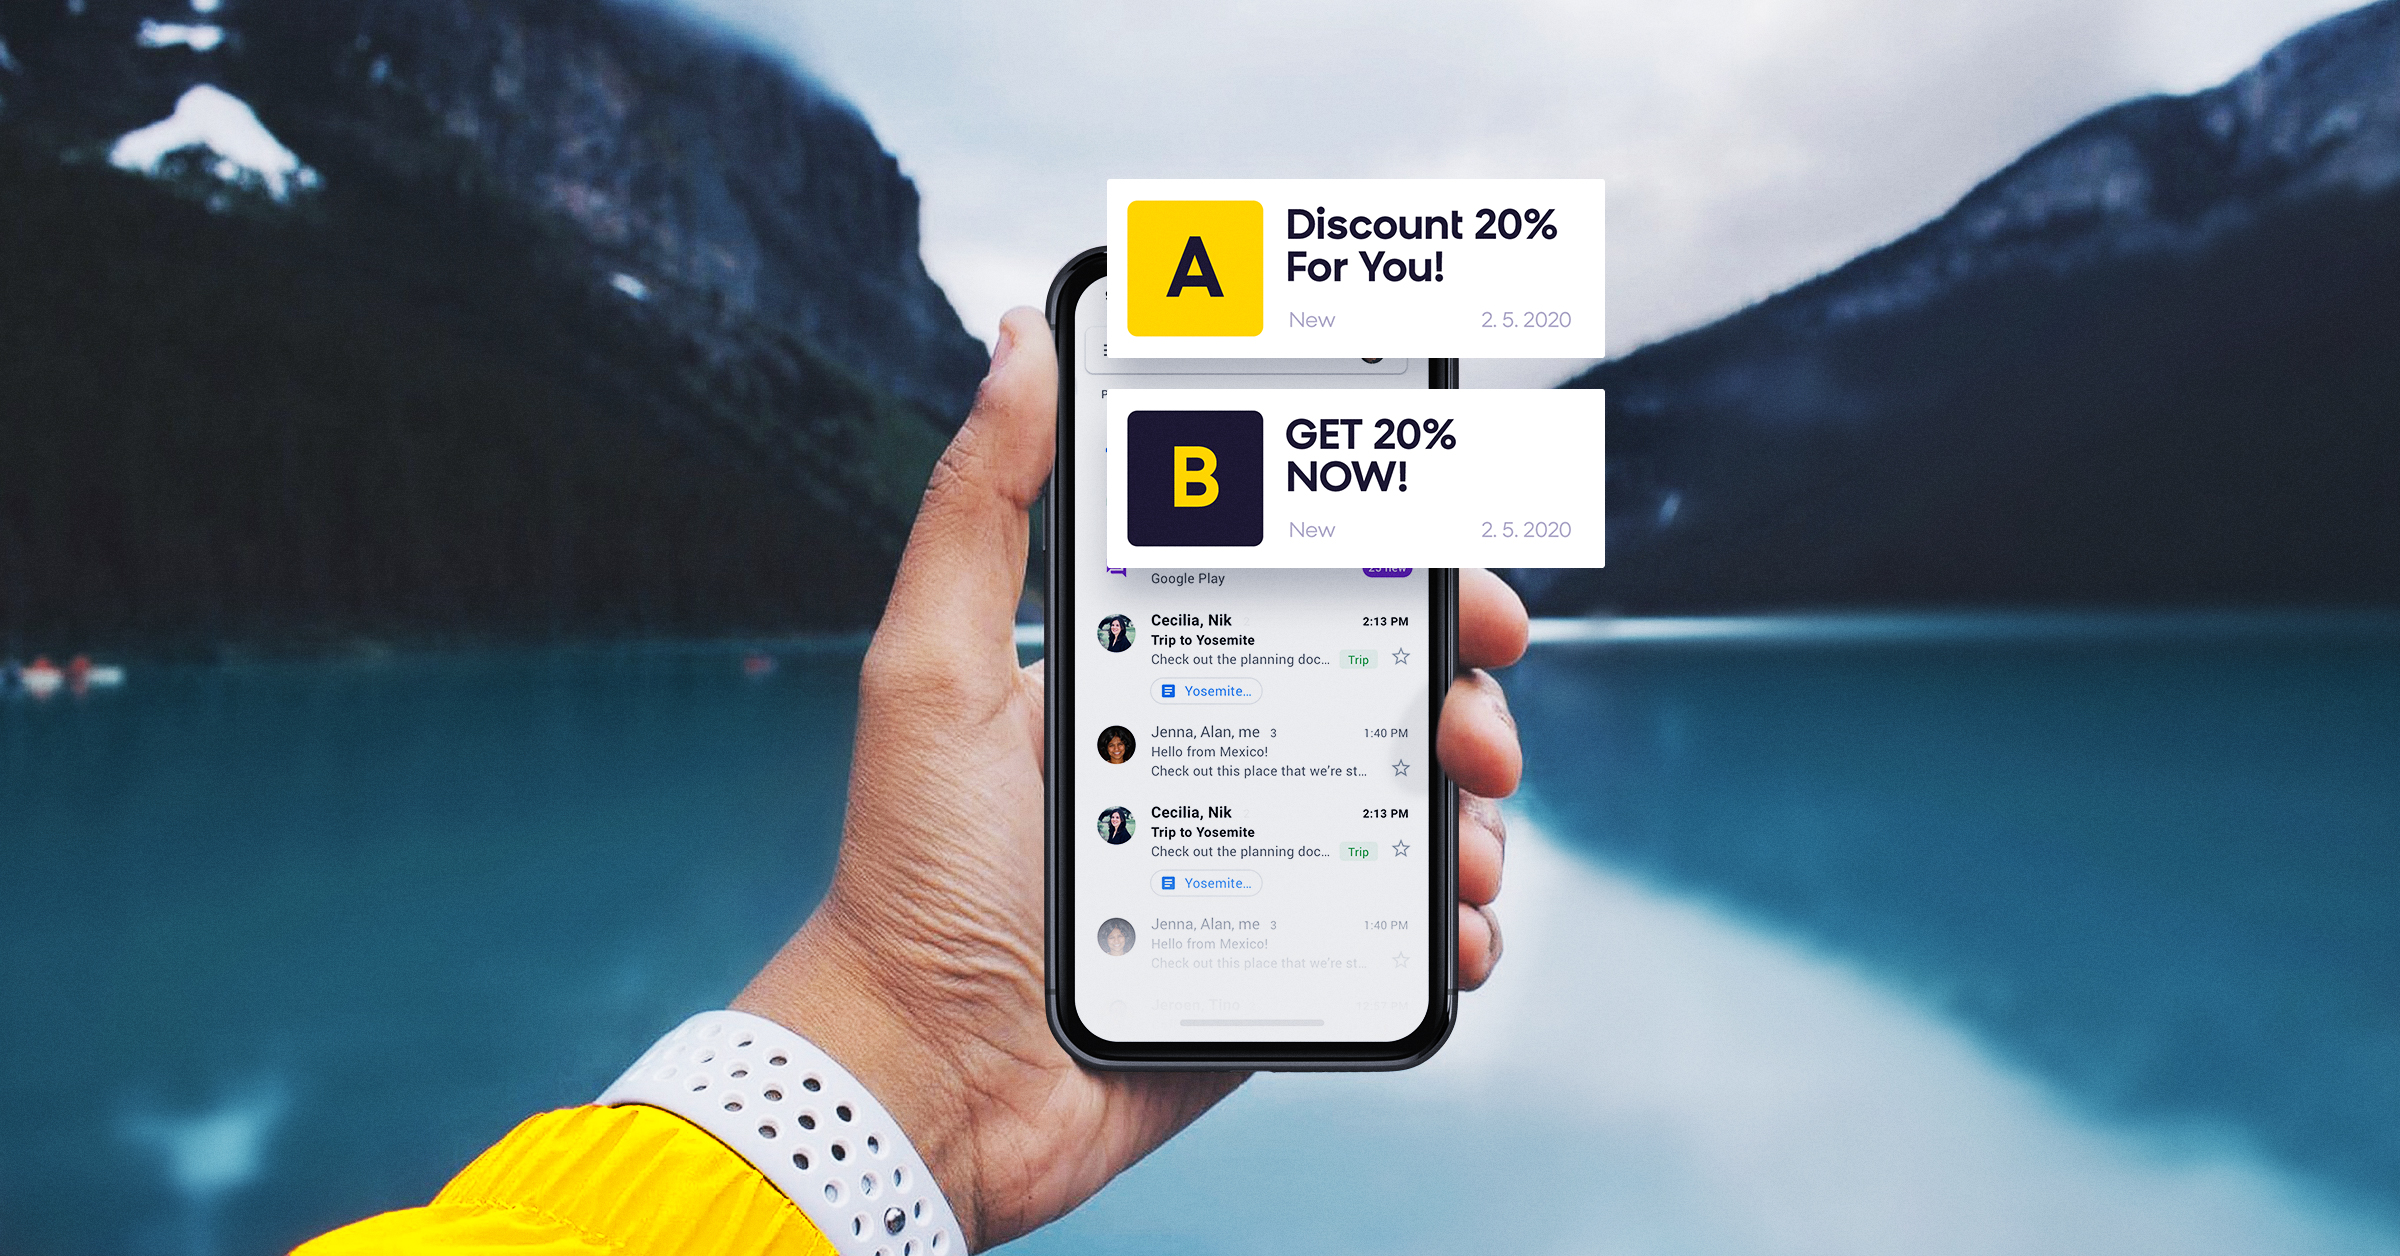

####  In this article, we will be run an A/B test by formulating a hypothesis, testing it and then interpreting the finl results.Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Step by step guide:
-Designing our experiment

-Collecting and preparing the data

-Visualising the results

-Testing the hypothesis

-Drawing conclusions

## Formulating a hypothesis
To design the experiment,we want to make sure that we formulate a hypothesis at the start itself.We will choose a two-tailed test:

We can state our hypothesis in terms of words or in terms of pold and pnew , which are the converted rates for the old and new pages.We have set a confidence level of 95% (alphya = 0.05).

H0:pnew−pold=0

 H1:pnew−pold ≠0

### Choosing the variables

#### Our Independent variable is group and 2 sets for our group are control and treatment.The only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.


#### We are interested in conversion rate as our Dependent Variable:
0 - The user did not buy the product during this user session 

1 - The user bought the product during this user session

 ## 1. Import the libraries

In [42]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Data

### For our data, we’ll use a dataset from Kaggle which contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page).

In [43]:
df = pd.read_csv('C:/Users/faiza kauser/Downloads/ab_data.csv.zip')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

## 3. Info

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


## The dataset contains 5 variables. Let’s see what each variable holds:

userid: A unique number that identifies every person.

timestamp: Timestamp for the session.

group: Which group the user was assigned to for that session {control, treatment}

landing_page: Which design each user saw on that session {old_page, new_page}

converted: Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

## 4. Shape

In [45]:
df.shape

(294478, 5)

In [52]:
 ## The number of unique users in the dataset
df.user_id.nunique()

290584

##

## 5. EDA

###  While performing the EDA check for null values , duplicates, any incorrect data and the type of data.

In [12]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [13]:
df.duplicated().sum()

0

### From the above data, it can be seen that:

The values in the dataset do not have any null values.

The userid contains all unique ids.

The timestamp,group and landing_page variables are of object datatype while user_id and converted are integer variables.

In [46]:
# Probability of an individual converting regardless of the page they receive
df['converted'].mean()

0.11965919355605512

In [48]:
 #probability of an individual in the control group to be converted
control_group = len(df.query('group=="control" and converted==1'))/len(df.query('group=="control"'))
control_group

0.12039917935897611

In [49]:
#probability of an individual in the treatment group to be converted
treatment_group = len(df.query('group=="treatment" and converted==1'))/len(df.query('group=="treatment"'))
treatment_group

0.11891957956489856

In [50]:
# The probability of individual received new page
len(df.query('landing_page=="new_page"'))/len(df.index)

0.5

In [51]:
# The probability of individual received old page
len(df.query('landing_page=="old_page"'))/len(df.index)

0.5

### It is clear that there is no more conversion between new page and old page. As the converting rate is similar in both cases so it is important to consider other factors.

In [18]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965

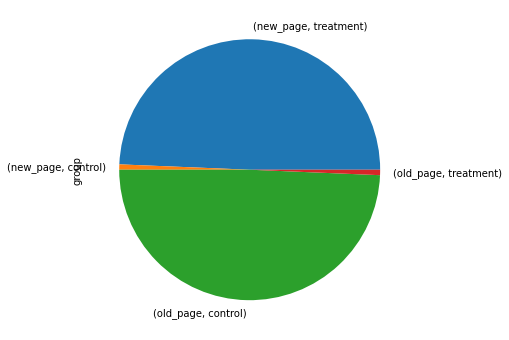

In [17]:
df.groupby('landing_page')['group'].value_counts().plot(kind = 'pie',figsize = (6,6));

## We’ll actually only use the group and converted columns for the analysis. let’s make sure there are no users that have been sampled multiple times.

In [20]:
id_counts = df['user_id'].value_counts(ascending=False)
multi_users = id_counts[id_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


### Remove the multiple counts from the DataFrame to avoid sampling the same users twice.

In [21]:
drop_multi_users = id_counts[id_counts > 1].index

df = df[~df['user_id'].isin(drop_multi_users)]

## Check the shape again

In [22]:
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


## 6. Sampling

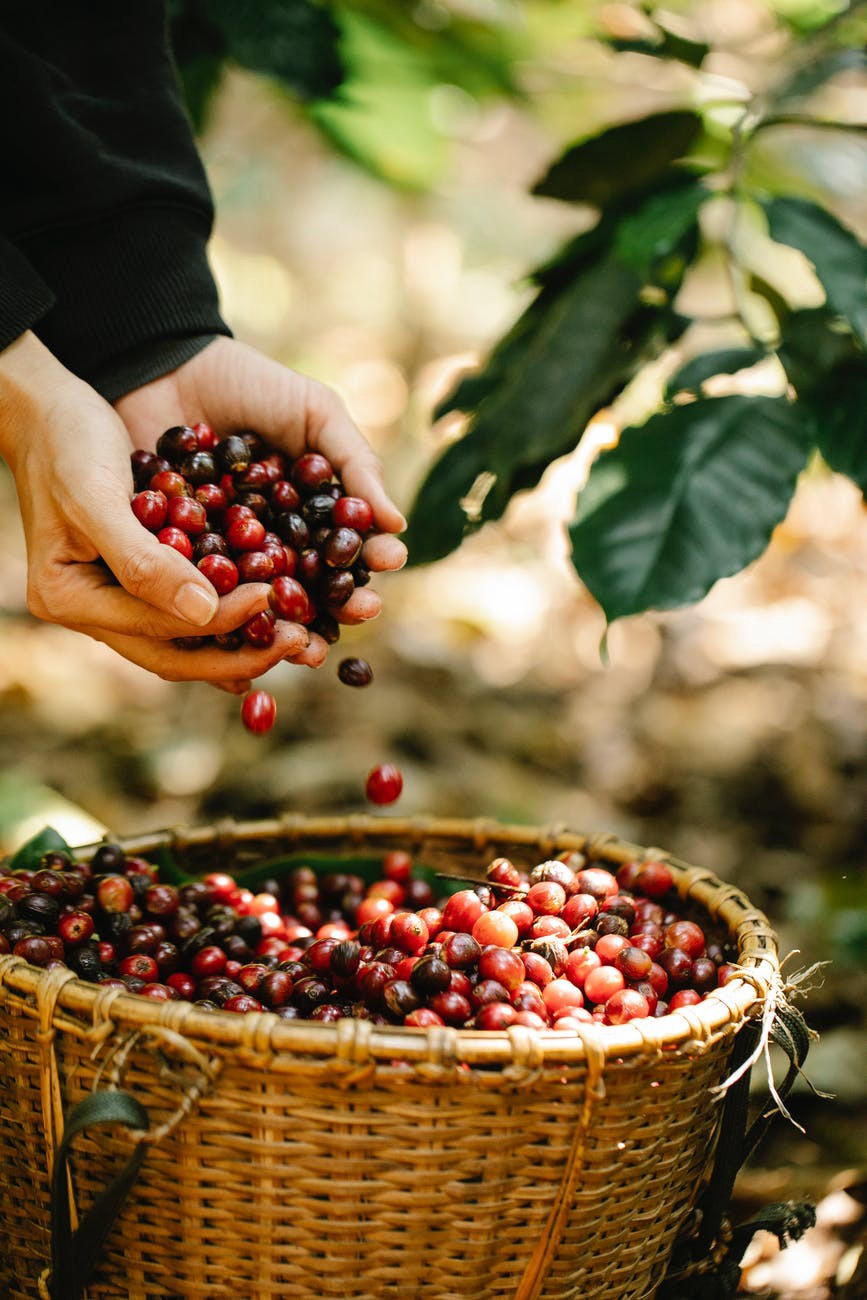

### A crucial part of A/B testing is determining the minimum sample size of the control and experimental groups, which needs to be determined using the defined power of the test (1-beta), the significance level (alpha), Minimum Detectable Effect (MED), and the variances of the two Normally Distributed samples of equal size.

In [26]:
import statsmodels.stats.api as sms
from math import ceil
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [28]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

df_test = pd.concat([control_sample, treatment_sample], axis=0)
df_test.reset_index(drop=True, inplace=True)

In [31]:
df_test

user_id                   timestamp      group landing_page  converted
0      763854  2017-01-21 03:43:17.188315    control     old_page          0
1      690555  2017-01-18 06:38:13.079449    control     old_page          0
2      861520  2017-01-06 21:13:40.044766    control     old_page          0
3      630778  2017-01-05 16:42:36.995204    control     old_page          0
4      656634  2017-01-04 15:31:21.676130    control     old_page          0
...       ...                         ...        ...          ...        ...
9435   908512  2017-01-14 22:02:29.922674  treatment     new_page          0
9436   873211  2017-01-05 00:57:16.167151  treatment     new_page          0
9437   631276  2017-01-20 18:56:58.167809  treatment     new_page          0
9438   662301  2017-01-03 08:10:57.768806  treatment     new_page          0
9439   944623  2017-01-19 10:56:01.648653  treatment     new_page          1

[9440 rows x 5 columns]

In [32]:
df_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

## 7. Visualization of results

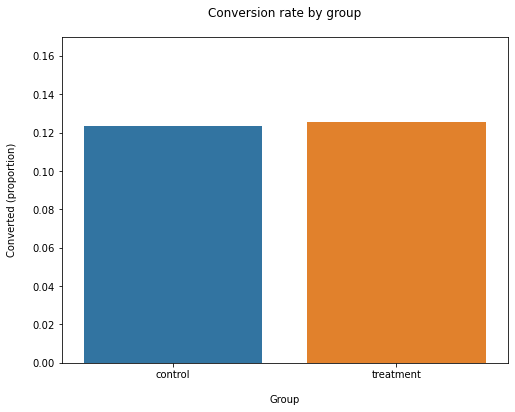

In [34]:
plt.figure(figsize=(8,6))

sns.barplot(x=df_test['group'], y=df_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### The conversion rates for  groups are close. There is some variation in results when sampling from a population.

## 4. Testing the hypothesis

In [40]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [41]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


### Conclusion

the variable does not have significant p-values. At p-value=0.732, we fail to reject the null hypothesis.Hence, we conclude that there is not sufficient evidence to suggest that our new design  perform significantly different (let alone better) than our old one that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.